CoVNet-X: COVID19 Chest XRays classification model 
By Taikhum, Yash, Shreyas
The model uses Xception/t as base model pre-trained on ImageNet, retrained on Chest X-rays dataset 





In [ ]:
#Download and unzip dataset if reqiored

!gdown https://drive.google.com/drive/folders/1iBmeYCsizh-pMBjH0ovC0MEXUfvd19Qr


Mount Gogle Drive to save and load models n datasets

In [1]:
#Mount Google Drive


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#copy dataset folder from google drive
!cp -R /content/drive/"MyDrive"/Dataset/covid-19 /content


In [48]:
#import libraries and packages

from numpy.random import seed
seed(8) #1
import matplotlib.pyplot as plt

import tensorflow
tensorflow.random.set_seed(7)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf

from tensorflow.python.keras import models
from tensorflow.python.keras import layers

from tensorflow.keras import optimizers




In [27]:
print(os.listdir("/content/covid-19/four_classes/train"))

#Print and remove zips once done



['pneumonia_viral', 'pneumonia_bacterial', 'normal', 'covid']


In [13]:
ls covid-19/four_classes/train

covid/  normal/  pneumonia_bacterial/  pneumonia_viral/


**Crete Data Generators to preprocess and prepare training and validation**

In [101]:

from os import listdir
data_list = listdir('/content/covid-19/four_classes/train')
#data_list = listdir('/content/drive/My Drive/Datasets/covid-19/four_classes/train')

#Delete some classes that may interfere

print(len(data_list))


DATASET_PATH  = '/content/covid-19/four_classes/train'
test_dir =  '/content/covid-19/four_classes/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 80
LEARNING_RATE =0.0001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')



# For multiclass use categorical n for binary use binary
train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"   #For multiclass use categorical n for binary use binary
                                                  )
valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"  #For multiclass use categorical n for binary use binary
                                                 
                                                  )



4
Found 1119 images belonging to 4 classes.
Found 277 images belonging to 4 classes.


In [ ]:
path="/content/covid-19/four_classes/"
!ls -a /content/covid-19/four_classes/train/.ipynb_checkpoints
!rm -R /content/covid-19/four_classes/test/.ipynb_checkpoints 
!pwd

Create a new model or Use Pre trained CNN Model and modify according to the need. 

In [ ]:
#Simple CNN model based on Xception. Set dense layer neuron count same as the no. of output classes 
#If you wnna use a saved model then skip this step


from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = True


model = models.Sequential()
model.add(conv_base)




model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy',     #for multiclass use categorical_crossentropy
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

**Load an already saved model (If there is a trained model already saved on drive)**

In [92]:
#Load saved model from .hs file, otherwise disable this line
model=load_model('/content/drive/MyDrive/4-class-Covid19-Mod_best.h5')
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 1028      
Total params: 34,035,756
Trainable params: 33,981,228
Non-trainable params: 54,528
_____________________________________

Training

In [96]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
result=model.fit(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )



20
5


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


19/19 [==============================] - 5s 268ms/step - loss: 0.3692 - acc: 0.8587 - val_loss: 0.4928 - val_acc: 0.9250


Evaluation

In [ ]:
#Plot the accuracy and loss graphs



def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 80)

In [100]:
#Save the trained model and copy to drive

model.save('4-class-Covid19-Mod-final.h5')
#!cp /content/"4-class-Covid19-Mod-Xception.h5" /content/drive/"My Drive"/"Colab Notebooks"


**Evaluate using evaluate Generator**

In [102]:
# Create evaluate data generator from test set
#Dont forget shuffle false

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '/content/covid-19/four_classes/test'

eval_generator = test_datagen.flow_from_directory(test_dir,target_size=IMAGE_SIZE,batch_size=1, 
                                                  shuffle=False, seed=42, class_mode="categorical")
eval_generator.reset()    


Found 242 images belonging to 4 classes.


In [103]:
#Evalute the trained model on evaluate generator
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

242/242 [==============================] - 4s 18ms/step - loss: 0.3905 - acc: 0.8802
Test loss: 0.3905360996723175
Test accuracy: 0.8801652789115906


**Create DataGen on single folder/class and predict !**

In [104]:
IMAGE_SIZE    = (150, 150)
test_datagen = ImageDataGenerator(rescale=1. / 255)
pred_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        
        seed=42,
        
        class_mode="categorical")
pred_generator.reset()   

count=[0,0,0,0]

files=pred_generator.filenames

for i in range(len(files)):
  x,y = pred_generator.next()
  img = x
  predict=model.predict(img)
  
  p=np.argmax(predict, axis=-1)
  print(str(p[0])+" "+files[pred_generator.batch_index-1])
  #print(predict)
  #p=model.predict_classes(img)
  count[p[0]]+=1
  
#print(str(p[0])+" "+files[i]) 
print(count)
  


Found 242 images belonging to 4 classes.
0 covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
0 covid/SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg
0 covid/X-ray_of_cyst_in_pneumocystis_pneumonia_1.jpg
0 covid/covid-19-pneumonia-41.jpg
0 covid/covid-19-pneumonia-58-day-10.jpg
0 covid/covid-19-pneumonia-67.jpeg
0 covid/covid-19-pneumonia-evolution-over-a-week-1-day6.jpg
0 covid/covid-19-pneumonia-rapidly-progressive-3-days.jpg
0 covid/covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-2.jpg
0 covid/covid-s3-55.jpeg
0 covid/covid-s3-60.jpeg
0 covid/figure1-5e75d0940b71e1b702629659-98-right.jpeg
0 covid/figure1-5e7c1b8d98c29ab001275405-98-later.jpeg
0 covid/jkms-35-e79-g001-l-c.jpg
0 covid/pneumococcal-pneumonia-day0.jpg
0 covid/pneumocystis-jirovecii-pneumonia-2.jpg
0 covid/pneumocystis-pneumonia-2-L.png
0 covid/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day1.jpg
0 covid/streptococcus-pneumoniae-pneumonia-temporal

### **`Predict Results using predict generator and evaluate the accuracy and Confusion matrix `**

[[20  0  0  0]
 [ 2 73  1  1]
 [ 0  2 70  3]
 [ 0  5 15 50]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       0.91      0.95      0.93        77
           2       0.81      0.93      0.87        75
           3       0.93      0.71      0.81        70

    accuracy                           0.88       242
   macro avg       0.89      0.90      0.89       242
weighted avg       0.89      0.88      0.88       242



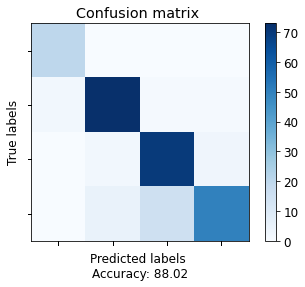

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report



filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))
pp=predict
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)
names=["covid","normal","pneumonia_bac","pneumonia_vir"]
#print(confusion_matrix(classes,predict))

font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
cm = confusion_matrix(classes, predict)
print(cm)
print(classification_report(classes,predict))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(acc*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**Test Single image**

In [68]:
import cv2
from skimage import transform

img_r = cv2.imread('/content/covid-19/four_classes/test/covid/covid-s3-55.jpeg')


img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))

img = np.expand_dims(img2, axis=0)

r=model.predict(img)

names= dict((v,k) for k,v in labels.items())
index = np.argmax(r)
name=names.get(index,"Unknown")

p=round(r.max()*100, 3)  #to find maximum score

scores=r
print(scores)

font = {
'family': 'Times New Roman',
'size': 9,

}
plt.rc('font', **font)

#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2) 


NameError: ignored

**Test Whole Folder**

In [47]:
import cv2
from skimage import transform

count=[0,0,0,0]
folder_name = "/content/covid-19/four_classes/test/covid"
files=os.listdir(folder_name)
for i in range(len(files)):
  img_r = cv2.imread(folder_name+"/"+files[i])

  img = np.array(img_r).astype('float32')/255

  img = transform.resize(img, (150, 150, 3))
  img = np.expand_dims(img, axis=0)
  
  predict=model.predict(img)
  p=np.argmax(predict, axis=-1)
  #p=model.predict_classes(img)
  count[p[0]]+=1
  print(str(p[0])+" "+files[i]) 
  
  print()
  
  
print(count)

0 SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg

0 SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day12.jpeg

0 X-ray_of_cyst_in_pneumocystis_pneumonia_1.jpg

0 covid-19-pneumonia-evolution-over-a-week-1-day6.jpg

0 covid-19-pneumonia-rapidly-progressive-3-days.jpg

0 covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-2.jpg

0 figure1-5e75d0940b71e1b702629659-98-right.jpeg

0 figure1-5e7c1b8d98c29ab001275405-98-later.jpeg

0 jkms-35-e79-g001-l-c.jpg

0 pneumococcal-pneumonia-day0.jpg

0 pneumocystis-jirovecii-pneumonia-2.jpg

0 pneumocystis-pneumonia-2-L.png

0 post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day1.jpg

0 streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg

0 wong-0003.jpg

0 covid-19-pneumonia-67.jpeg

0 covid-19-pneumonia-41.jpg

0 covid-19-pneumonia-58-day-10.jpg

0 covid-s3-60.jpeg

0 covid-s3-55.jpeg

[20, 0, 0, 0]
